# Predicting lung cancer survival time by OWKIN

### Problem

- supervised survival prediction problem
- predict the survival time of a patient (remaining days to live) from one three-dimensional CT scan (grayscale image) and a set of pre-extracted quantitative imaging features, as well as clinical data

### Import

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import autosklearn.regression
import time

# concordance index (C-index)
from metrics_t9gbvr2 import cindex

/home/damien/.local/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


### Data

- x_train : data_Q0G7b5t
- y_train : output_VSVxRFU.csv
- x_test : data_9Cbe5hx

In [2]:
data_folder_path = "../data"
training_folder_path = os.path.join(data_folder_path, "data_Q0G7b5t")
test_folder_path = os.path.join(data_folder_path, "data_9Cbe5hx")

training_ct_scan_names = [os.path.join(root,file_name) for root,_,file_names in os.walk(training_folder_path) for file_name in file_names if file_name.endswith('.npz')]
test_ct_scan_names = [os.path.join(root,file_name) for root,_,file_names in os.walk(test_folder_path) for file_name in file_names if file_name.endswith('.npz')]

print("Number of training ct scans : {}".format(len(training_ct_scan_names)))
print("Number of test ct scans : {}".format(len(test_ct_scan_names)))

training_features_path = os.path.join(training_folder_path, "features")
test_features_path = os.path.join(test_folder_path, "features")

submission_file_path = "../random_submission_example"

Number of training ct scans : 300
Number of test ct scans : 125


In [3]:
archive = np.load(training_ct_scan_names[0])
scan = archive['scan']
mask = archive['mask']
# scan.shape equals mask.shape

In [4]:
df_train_output = pd.read_csv(os.path.join(data_folder_path, "output_VSVxRFU.csv"), index_col=0)
p0 = df_train_output.loc[202]
print("p0.Event", p0.Event) # prints 1 or 0
print("p0.SurvivalTime", p0.SurvivalTime)
# prints time to event (time to death or time to last known alive) in days

p0.Event 0
p0.SurvivalTime 1378


In [5]:
df_train_output.sample(5)

,SurvivalTime,Event
PatientID,,
225,685,1
277,21,0
422,315,0
238,1174,0
294,24,1


### Interpretation

(`1=death observed`, `0=escaped from study`)

### Load training data

In [6]:
file_name = os.path.join(training_features_path, "clinical_data.csv")
df_training_clinical_data = pd.read_csv(file_name, delimiter=',', index_col=0)
print("Nb rows in df_training_clinical_data : {}".format(len(df_training_clinical_data)))

file_name = os.path.join(training_features_path, "radiomics.csv")
df_training_radiomics = pd.read_csv(file_name, delimiter=',', index_col=0, skiprows=[0,2], header=[0])
df_training_radiomics.index.name = ["PatientID"]
print("Nb rows in df_training_radiomics : {}".format(len(df_training_radiomics)))

Nb rows in df_training_clinical_data : 300
Nb rows in df_training_radiomics : 300


### Load test data

In [7]:
file_name = os.path.join(test_features_path, "clinical_data.csv")
df_test_clinical_data = pd.read_csv(file_name, delimiter=',', index_col=0)
print("Nb rows in df_training_clinical_data : {}".format(len(df_test_clinical_data)))

file_name = os.path.join(test_features_path, "radiomics.csv")
df_test_radiomics = pd.read_csv(file_name, delimiter=',', index_col=0 , skiprows=[0,2], header=[0])
df_test_radiomics.index.name = ["PatientID"]
print("Nb rows in df_training_radiomics : {}".format(len(df_test_clinical_data)))

Nb rows in df_training_clinical_data : 125
Nb rows in df_training_radiomics : 125


### clinical_data.csv

In [8]:
df_training_clinical_data.sample(5)

,Histology,Mstage,Nstage,SourceDataset,Tstage,age
PatientID,,,,,,
295,large cell,0,2,l1,2,72.7830
142,adenocarcinoma,0,3,l1,2,59.7919
196,large cell,0,0,l1,1,76.4846
250,large cell,3,3,l1,3,73.0595
385,nos,0,2,l1,4,65.3963


#### Are there NaN values in df_training_clinical_data ?

In [9]:
df_training_clinical_data.isnull().sum()

Histology        20
Mstage            0
Nstage            0
SourceDataset     0
Tstage            0
age              16
dtype: int64

### Remark

There are NaN values in columns Histology and age. We will not use these in our study so no problem.

### radiomics.csv

In [10]:
df_training_radiomics.sample(5)

,original_shape_Compactness1,original_shape_Compactness2,original_shape_Maximum3DDiameter,original_shape_SphericalDisproportion,original_shape_Sphericity,original_shape_SurfaceArea,original_shape_SurfaceVolumeRatio,original_shape_VoxelVolume,original_firstorder_Energy,original_firstorder_Entropy,...,original_glrlm_LongRunEmphasis,original_glrlm_GrayLevelNonUniformity,original_glrlm_RunLengthNonUniformity,original_glrlm_RunPercentage,original_glrlm_LowGrayLevelRunEmphasis,original_glrlm_HighGrayLevelRunEmphasis,original_glrlm_ShortRunLowGrayLevelEmphasis,original_glrlm_ShortRunHighGrayLevelEmphasis,original_glrlm_LongRunLowGrayLevelEmphasis,original_glrlm_LongRunHighGrayLevelEmphasis
[PatientID],,,,,,,,,,,,,,,,,,,,,
318,0.017031,0.103054,85.586214,2.132941,0.468836,7554.908076,0.381136,19907.0,2.844528e+08,3.541945,...,3.732719,1328.477187,7604.739422,0.662987,0.001765,867.735631,0.001527,658.051593,0.004608,3564.660874
290,0.025304,0.227507,19.949937,1.638080,0.610471,847.228076,0.766000,1134.0,3.344801e+08,5.167378,...,1.173810,33.099106,978.164039,0.949125,0.007477,576.249086,0.007290,544.412905,0.008312,737.276999
261,0.035752,0.454151,36.619667,1.300968,0.768658,3143.972679,0.281441,11204.0,1.299546e+09,4.747964,...,2.126745,336.573622,6761.904881,0.807157,0.003026,791.295506,0.002829,659.103280,0.004400,2243.689318
141,0.038652,0.530817,25.079872,1.235051,0.809683,1402.956508,0.389701,3621.0,4.374857e+08,4.955476,...,1.284135,121.111865,2875.994315,0.921420,0.005340,633.634364,0.005109,589.493627,0.006481,855.330191
406,0.026370,0.247075,28.513155,1.593642,0.627494,1523.109185,0.548210,2809.0,8.577067e+08,5.125872,...,1.350421,77.557194,2183.839359,0.910754,0.012103,511.677250,0.011480,463.452901,0.015142,830.430427


#### Are there NaN values in df_training_radiomics ?

In [11]:
df_training_radiomics.isnull().sum().sum()

0

### Remark

There are no NaN values in df_training_radiomics.

### Make sure that PatientID are aligned in df_training_clinical_data and df_training_radiomics

In [12]:
(df_training_clinical_data.index.values==df_training_radiomics.index.values).sum()

300

$300$ means that all PatientIDs are aligned in both training dataframes

### Make sure that PatientID are aligned in df_test_clinical_data and df_test_radiomics

In [13]:
(df_test_clinical_data.index.values==df_test_radiomics.index.values).sum()

125

$125$ means that all PatientIDs are aligned in both test dataframes

### Baseline model for survival regression on NSCLC clinical data : Cox proportional hazard (Cox-PH) model

This baseline is trained on a selection of features from both clinical data file and radiomics file. A Cox-PH model was fitted on

- 1 - Tumor sphericity, a measure of the roundness of the shape of the tumor region relative to a sphere, regardless its dimensions (size).
- 2 - The tumor's surface to volume ratio is a measure of the compactness of the tumor, related to its size.
- 3 - The tumor's maximum 3d diameter The biggest diameter measurable from the tumor volume
- 4 - The dataset of origin
- 5 - The N-tumoral stage grading of the tumor describing nearby (regional) lymph nodes involved
- 6 - The tumor's joint entropy, specifying the randomness in the image pixel values
- 7 - The tumor's inverse different, a measure of the local homogeneity of the tumor
- 8 - The tumor's inverse difference moment is another measurement of the local homogeneity of the tumor

### Name of variables

- 1 - original_shape_Sphericity
- 2 - original_shape_SurfaceVolumeRatio
- 3 - original_shape_Maximum3DDiameter
- 4 - l1 (0) or l2 (1)
- 5 - Nstage
- 6 - original_firstorder_Entropy
- 7 - inverse difference (original_glcm_Id)
- 8 - inverse difference moment (original_glcm_Idm) (according to [here](https://static-content.springer.com/esm/art%3A10.1038%2Fncomms5006/MediaObjects/41467_2014_BFncomms5006_MOESM716_ESM.pdf), ctr+F IDMN and [here](https://github.com/cerr/CERR/wiki/GLCM_global_features))

### Remark

Variables used in the baseline use quantitve and qualitive variables. (dataset of origin (l1 or l2)) makes no sens 

In [14]:
df_training_clinical_data.head(5)

,Histology,Mstage,Nstage,SourceDataset,Tstage,age
PatientID,,,,,,
202,Adenocarcinoma,0,0,l2,2,66.0000
371,large cell,0,2,l1,4,64.5722
246,squamous cell carcinoma,0,3,l1,2,66.0452
240,nos,0,2,l1,3,59.3566
284,squamous cell carcinoma,0,3,l1,4,71.0554


### Encode SourceDataset ("dataset of origin") with value between 0 and n_datasets-1.

In [15]:
encoder_source_dataset = LabelEncoder()
encoder_source_dataset.fit(df_training_clinical_data["SourceDataset"])
df_training_clinical_data["SourceDataset"] = encoder_source_dataset.transform(df_training_clinical_data["SourceDataset"])

In [16]:
df_training_clinical_data.head(5)

,Histology,Mstage,Nstage,SourceDataset,Tstage,age
PatientID,,,,,,
202,Adenocarcinoma,0,0,1,2,66.0000
371,large cell,0,2,0,4,64.5722
246,squamous cell carcinoma,0,3,0,2,66.0452
240,nos,0,2,0,3,59.3566
284,squamous cell carcinoma,0,3,0,4,71.0554


In [17]:
df_X_train = pd.concat([df_training_radiomics[["original_shape_Sphericity", 
                                               "original_shape_SurfaceVolumeRatio", 
                                               "original_shape_Maximum3DDiameter",
                                               "original_firstorder_Entropy",
                                               "original_glcm_Id",
                                               "original_glcm_Idm"]],
                        df_training_clinical_data[["SourceDataset",
                                                   "Nstage"]]
                       ], sort=False, axis=1)

In [18]:
#df_X_train = df_X_train.astype(float)
df_X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300 entries, 202 to 366
Data columns (total 8 columns):
original_shape_Sphericity            300 non-null float64
original_shape_SurfaceVolumeRatio    300 non-null float64
original_shape_Maximum3DDiameter     300 non-null float64
original_firstorder_Entropy          300 non-null float64
original_glcm_Id                     300 non-null float64
original_glcm_Idm                    300 non-null float64
SourceDataset                        300 non-null int64
Nstage                               300 non-null int64
dtypes: float64(6), int64(2)
memory usage: 21.1 KB


### AutoML sklearn

In [19]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection._split import BaseShuffleSplit, _validate_shuffle_split
from sklearn.utils import check_random_state
from sklearn.utils.validation import _num_samples

In [20]:
random_state = 42
test_size = 0.2 #0.33
n_splits = 1
time_left_for_this_task = 60 #600 #3600 #1200 #60 # in seconds
per_run_time_limit = 30

In [21]:
suffle_split = ShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=random_state)
ind_train, ind_test = [_tuple for _tuple in suffle_split._iter_indices(df_X_train, y=df_train_output["SurvivalTime"], groups=None)][0]
n_train = len(ind_train)
n_test = len(ind_train)

In [22]:
class ShuffleSplit(BaseShuffleSplit):
    """
    Taken from following links
    https://github.com/automl/auto-sklearn/pull/442/files ctr+F Unknown CrossValidator.
    https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/model_selection/_split.py ctrl +F
    """
    
    def __init__(self, n_splits=10, test_size=None, train_size=None,
                 random_state=None):
        n_splits = 1 # !!!!!!!!!!!!!!!!!!!!!!!!!!!!! PROBLEM : n_splits stays at 10 even when changing default value

        super().__init__(
            n_splits=n_splits,
            test_size=test_size,
            train_size=train_size,
            random_state=random_state)
        self._default_test_size = 0.1

    def _iter_indices(self, X, y=None, groups=None):
        n_samples = _num_samples(X)
        n_train, n_test = _validate_shuffle_split(
            n_samples, self.test_size, self.train_size,
            default_test_size=self._default_test_size)

        rng = check_random_state(self.random_state)
        for i in range(self.n_splits):
            # random partition
            permutation = rng.permutation(n_samples)
            ind_test = permutation[:n_test]
            ind_train = permutation[n_test:(n_test + n_train)]
            yield ind_train, ind_test

In [23]:
automl = autosklearn.regression.AutoSklearnRegressor(time_left_for_this_task=time_left_for_this_task, # in seconds
                                                     per_run_time_limit=per_run_time_limit,
                                                     resampling_strategy=ShuffleSplit,
                                                     resampling_strategy_arguments={'n_splits': n_splits,
                                                    'test_size': test_size,
                                                    'random_state': random_state})

def my_cindex(solution, prediction, patient_ids, events, ind_train, ind_test, n_train, n_test):
    prediction = prediction.ravel()
    
    if len(solution)==n_train:
        ind = ind_train
    else:
        ind = ind_test
       
    #print("solution.shape", solution.shape)
    #print("prediction.shape", prediction.shape)
    #print("patient_ids.shape", patient_ids.shape)
    #print("events.shape", events.shape)
    
    #print(autosklearn.metrics.r2(solution, prediction))
    #return autosklearn.metrics.r2(solution, prediction)

    data_solution = {"PatientID" : patient_ids[ind],
                     "SurvivalTime" : solution,
                     "Event" : events[ind]
                    }
    df_solution = pd.DataFrame(data_solution)
    df_solution = df_solution.set_index("PatientID")
    
    data_prediction = {"PatientID" :patient_ids[ind],
                       "SurvivalTime" : prediction,
                       "Event" : events[ind]*np.nan # because "`Event`column, whose value does not matter" in metrics_t9gbvr2.py
                      }
    df_prediction = pd.DataFrame(data_prediction)
    df_prediction = df_prediction.set_index("PatientID")
    
    print(cindex(df_solution, df_prediction))
    return cindex(df_solution, df_prediction)

cindex_scorer = autosklearn.metrics.make_scorer(
        name="cindex",
        score_func=my_cindex,
        optimum=1,
        greater_is_better=True,
        needs_proba=False,
        needs_threshold=False,
        patient_ids = df_train_output.index.values,
        events = df_train_output["Event"].values,
        ind_train = ind_train,
        ind_test = ind_test,
        n_train = n_train,
        n_test = n_test
    )

start_time = time.time()
automl.fit(df_X_train.copy(), df_train_output["SurvivalTime"].copy(), dataset_name='data_Q0G7b5t', metric=cindex_scorer) #, metric=cindex_scorer
# Docs for metric in autoML skearln
# https://automl.github.io/auto-sklearn/master/examples/example_metrics.html
# (Metric must be instance of autosklearn.metrics.Scorer.)

#https://automl.github.io/auto-sklearn/master/examples/example_crossvalidation.html
automl.refit(df_X_train.copy(), df_train_output["SurvivalTime"].copy())

execution_time = time.time()-start_time
print("execution_time", execution_time)

# https://automl.github.io/auto-sklearn/master/manual.html
# Cross validation : https://scikit-learn.org/stable/modules/cross_validation.html

/home/damien/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


[WARNING] [2020-01-26 16:37:37,441:AutoMLSMBO(1)::data_Q0G7b5t] Could not find meta-data directory /home/damien/.local/lib/python3.6/site-packages/autosklearn/metalearning/files/cindex_regression_dense
0.4999999999962321
[WARNING] [2020-01-26 16:37:37,470:EnsembleBuilder(1):data_Q0G7b5t] No models better than random - using Dummy Score!
0.4999999999962321
[WARNING] [2020-01-26 16:37:37,494:EnsembleBuilder(1):data_Q0G7b5t] No models better than random - using Dummy Score!


/home/damien/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


0.6510926902739179
0.9091456479555033
0.6510926902739179
0.6510926902739179


/home/damien/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


0.5817633760317878
0.7496153074190475


/home/damien/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


0.6085154483752184
0.658727503846485
0.5817633760317878


/home/damien/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


0.6085154483752184
0.5892991710581063
0.6510926902739179
0.6085154483752184
0.7845052518894865
0.5817633760317878
0.6510926902739179
0.660889223808132
0.6239638281791714
0.6586284853002364
0.6616428033107639
0.6254709871844351
0.660889223808132
0.6616428033107639
0.6284853051949625
0.6616428033107639
0.6616428033107639
0.6284853051949625
0.6616428033107639
0.6616428033107639
0.6314996232054899
0.6616428033107639
0.6616428033107639
0.6314996232054899
0.6616428033107639
0.6616428033107639
0.6405425772370721
0.6616428033107639
0.6616428033107639
0.6495855312686543
0.6616428033107639
0.6616428033107639
0.6503391107712861
0.6616428033107639
0.6616428033107639
0.6503391107712861
0.6616428033107639
0.6616428033107639
0.6503391107712861
0.6616428033107639
0.6616428033107639
0.6503391107712861
0.6616428033107639
0.6616428033107639
0.6503391107712861
0.6616428033107639
0.6616428033107639
0.6518462697765498
0.6616428033107639
0.6616428033107639
0.6510926902739179
0.6616428033107639
0.661642803310

/home/damien/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


0.6510926902739179
0.6051243406133752
0.6616428033107639
0.6616428033107639
0.568174215561271
0.6525998492791817
0.6616428033107639
0.6616428033107639
0.6525998492791817
0.6616428033107639
0.6616428033107639
0.6525998492791817
0.6616428033107639
0.6616428033107639
0.6616428033107639
0.6541070082844453
0.6616428033107639
0.6541070082844453
0.6616428033107639
0.6616428033107639
0.6541070082844453
0.6616428033107639
0.6616428033107639
0.6533534287818135
0.6616428033107639
0.6616428033107639
0.6556141672897091
0.660889223808132
0.6616428033107639
0.6548605877870772
0.6616428033107639
0.6616428033107639
0.6548605877870772
0.6616428033107639
0.6616428033107639
0.6556141672897091
0.6616428033107639
0.6616428033107639
0.6541070082844453
0.660889223808132
0.6616428033107639
0.6556141672897091
0.660889223808132
0.6616428033107639
0.6556141672897091
0.6616428033107639
0.6616428033107639
0.6556141672897091
0.6616428033107639
0.6616428033107639
0.6563677467923409
0.6616428033107639
0.66164280331076

/home/damien/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


0.6601356443055002
0.6213262999199599
0.6684250188344505
0.6684250188344505
0.6684250188344505
0.7440958051777988
0.6676714393318186
0.660889223808132
0.6684250188344505
0.6684250188344505
0.6684250188344505
0.6676714393318186
0.660889223808132
0.6684250188344505
0.6684250188344505
0.6684250188344505
0.6676714393318186
0.6601356443055002
0.6684250188344505
0.6684250188344505
0.6684250188344505
0.6676714393318186
0.6601356443055002
0.6684250188344505
0.6684250188344505
0.6684250188344505
0.6684250188344505
0.6631499623160275
0.6684250188344505
0.6684250188344505
0.6684250188344505
0.6691785983370824
0.6623963828133957
0.6684250188344505
0.6691785983370824
0.6691785983370824
0.6639035418186594
0.6623963828133957
0.6684250188344505
0.6691785983370824
0.6691785983370824
0.6639035418186594
0.6623963828133957
0.6684250188344505
0.6691785983370824
0.6691785983370824
0.6639035418186594
0.6623963828133957
0.6684250188344505
0.6691785983370824
0.6691785983370824
0.6639035418186594
0.662396382813

/home/damien/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


0.6691785983370824
0.6443104747502313
0.6691785983370824
0.6639035418186594
0.6631499623160275
0.6684250188344505
0.8634508597037107
0.6691785983370824
0.6691785983370824
0.6639035418186594
0.6631499623160275
0.6684250188344505
0.6691785983370824
0.6691785983370824
0.6639035418186594
0.6691785983370824
0.6631499623160275
0.6684250188344505
0.6691785983370824
0.6639035418186594
0.6631499623160275
0.6443104747502313
0.6213262999199599
0.6510926902739179
0.6051243406133752
0.6443104747502313
0.6213262999199599
0.6085154483752184
0.5892991710581063
0.5817633760317878
0.6510926902739179
0.6571213262949728
0.6563677467923409
0.660889223808132
0.6631499623160275
0.6171816126554848
0.6239638281791714
0.6631499623160275
0.660889223808132
0.6616428033107639
0.6676714393318186
0.6631499623160275
0.6495855312686543
0.6337603617133855
0.6669178598291868
0.6616428033107639
0.6669178598291868
0.6684250188344505
0.6676714393318186
0.6473247927607587
0.6337603617133855
0.6676714393318186
0.663149962316

/home/damien/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


0.5968349660844248
0.6691785983370824
0.6684250188344505
0.8359537030836717
0.6737000753528735
0.6737000753528735
0.6646571213212913
0.6654107008239231
0.6721929163476098
0.6691785983370824
0.6684250188344505
0.6737000753528735
0.6737000753528735
0.6646571213212913
0.6654107008239231
0.6721929163476098
0.6691785983370824
0.6684250188344505
0.6737000753528735
0.6737000753528735
0.6646571213212913
0.6654107008239231
0.6721929163476098
0.6691785983370824
0.6684250188344505
0.6737000753528735
0.6737000753528735
0.6646571213212913
0.6654107008239231
0.6721929163476098
0.6691785983370824
0.6684250188344505
0.6737000753528735
0.6737000753528735
0.6646571213212913
0.6654107008239231
0.6721929163476098
0.6691785983370824
0.6684250188344505
0.6737000753528735
0.6737000753528735
0.6646571213212913
0.6654107008239231
0.6721929163476098
0.6691785983370824
0.6684250188344505
0.6737000753528735
0.6737000753528735
0.6646571213212913
0.6654107008239231
0.6721929163476098
0.6691785983370824
0.6684250188

/home/damien/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


0.6103993971317981
0.6691785983370824
0.6684250188344505
0.6737000753528735
0.786077473740024
0.6737000753528735
0.6646571213212913
0.6654107008239231
0.6721929163476098
0.6691785983370824
0.6737000753528735
0.6684250188344505
0.6737000753528735
0.6646571213212913
0.6654107008239231
0.6721929163476098
0.6691785983370824
0.6684250188344505
0.6646571213212913
0.6721929163476098
0.6684250188344505
0.6737000753528735
0.6737000753528735
0.6654107008239231
0.6691785983370824
0.6737000753528735
0.6737000753528735
0.6646571213212913
0.6654107008239231
0.6721929163476098
0.6691785983370824
0.6684250188344505
0.6737000753528735
0.6737000753528735
0.6646571213212913
0.6654107008239231
0.6721929163476098
0.6691785983370824
0.6684250188344505
0.6737000753528735
0.6737000753528735
0.6646571213212913
0.6654107008239231
0.6721929163476098
0.6691785983370824
0.6684250188344505
0.6737000753528735
0.6737000753528735
0.6646571213212913
0.6654107008239231
0.6721929163476098
0.6691785983370824
0.66842501883

/home/damien/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


0.675960813860769
0.6194423511633803
0.6804822908765601
0.666164280326555
0.6819894498818238
0.681235870379192
0.7574095136142655
0.675960813860769
0.6578749057976047
0.6646571213212913
0.6774679728660327
0.6774679728660327
0.681235870379192
0.6669178598291868
0.6827430293844556
0.6819894498818238
0.6774679728660327
0.6586284853002364
0.6654107008239231
0.6789751318712964
0.6789751318712964
0.6834966088870875
0.6684250188344505
0.6842501883897193
0.6827430293844556
0.6782215523686645
0.6578749057976047
0.6654107008239231
0.681235870379192
0.6804822908765601
0.6850037678923512
0.670685757342346
0.686510926897615
0.6827430293844556
0.6797287113739282
0.6631499623160275
0.6676714393318186
0.6819894498818238
0.6819894498818238
0.6850037678923512
0.6721929163476098
0.6872645064002467
0.6834966088870875
0.6797287113739282
0.6623963828133957
0.6684250188344505
0.6819894498818238
0.681235870379192
0.6857573473949831
0.6714393368449779
0.686510926897615
0.6834966088870875
0.6782215523686645


/home/damien/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


0.7015825169502519
0.6631499623160275
0.6676714393318186
0.7010771392247935
0.6804822908765601
0.6797287113739282
0.6857573473949831
0.6699321778397141
0.6850037678923512
0.6834966088870875
0.6789751318712964
0.6623963828133957
0.6676714393318186
0.6850037678923512
0.6774679728660327
0.6789751318712964
0.666164280326555
0.6834966088870875
0.6827430293844556
0.6767143933634009
0.6593820648028683
0.6623963828133957
0.6782215523686645
0.6819894498818238
0.6819894498818238
0.6729464958502416
0.6834966088870875
0.6834966088870875
0.6699321778397141
0.6774679728660327
0.6616428033107639
0.6767143933634009
0.6804822908765601
0.6804822908765601
0.6714393368449779
0.6834966088870875
0.6834966088870875
0.6767143933634009
0.6593820648028683
0.6684250188344505
0.6767143933634009
0.6804822908765601
0.6601356443055002
0.6804822908765601
0.6714393368449779
0.6834966088870875
0.6834966088870875
0.6767143933634009
0.6593820648028683
0.6684250188344505
0.6767143933634009
0.6804822908765601
0.68048229087

/home/damien/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


0.6834966088870875
0.6563677467923409
0.6774679728660327
0.6601356443055002
0.7572088044418563
0.6691785983370824
0.6774679728660327
0.6804822908765601
0.6804822908765601
0.6714393368449779
0.6834966088870875
0.6834966088870875
0.6774679728660327
0.6601356443055002
0.6691785983370824
0.6774679728660327
0.6804822908765601
0.6804822908765601
0.6714393368449779
0.6834966088870875
0.6834966088870875
0.6774679728660327
0.6601356443055002
0.6691785983370824
0.6774679728660327
0.6804822908765601
0.6804822908765601
0.6714393368449779
0.6834966088870875
0.6834966088870875
0.6774679728660327
0.6601356443055002
0.6691785983370824
0.6774679728660327
0.6804822908765601
0.6804822908765601
0.6714393368449779
0.6834966088870875
0.6834966088870875
0.6774679728660327
0.6601356443055002
0.6691785983370824
0.6774679728660327
0.6804822908765601
0.6804822908765601
0.6714393368449779
0.6834966088870875
0.6834966088870875
0.6774679728660327


/home/damien/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


0.6601356443055002
0.5158251695515009
0.6691785983370824
0.6774679728660327
0.5155215093326316
0.6804822908765601
0.6804822908765601
0.6714393368449779
0.6834966088870875
0.6834966088870875
0.6774679728660327
0.6601356443055002
0.6691785983370824
0.6774679728660327
0.6804822908765601
0.6804822908765601
0.6714393368449779
0.6834966088870875
0.6834966088870875
0.6774679728660327
0.6601356443055002
0.6691785983370824
0.6774679728660327
0.6804822908765601
0.6804822908765601
0.6714393368449779
0.6834966088870875
0.6834966088870875
0.6774679728660327
0.6601356443055002
0.6691785983370824
0.6774679728660327
0.6804822908765601
0.6804822908765601
0.6714393368449779
0.6834966088870875
0.6834966088870875
0.6774679728660327
0.6601356443055002
0.6691785983370824
0.6774679728660327
0.6804822908765601
0.6804822908765601
0.6714393368449779


/home/damien/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


0.6834966088870875
0.6541070082844453
0.6834966088870875
0.6774679728660327
0.7477085702811616
0.6601356443055002
0.6691785983370824
0.6774679728660327
0.6804822908765601
0.6804822908765601
0.6714393368449779
0.6834966088870875
0.6834966088870875
0.6774679728660327
0.6601356443055002
0.6691785983370824
0.6804822908765601
0.6774679728660327
0.6804822908765601
0.6714393368449779
0.6834966088870875
0.6834966088870875
0.6774679728660327
0.6601356443055002
0.6691785983370824
0.6774679728660327
0.6804822908765601
0.6804822908765601
0.6714393368449779
0.6834966088870875
0.6834966088870875
0.6774679728660327
0.6601356443055002
0.6691785983370824
0.6774679728660327
0.6804822908765601
0.6804822908765601
0.6714393368449779
0.6834966088870875
0.6834966088870875
0.6774679728660327
0.6601356443055002
0.6691785983370824
0.6774679728660327
0.6804822908765601
0.6804822908765601
0.6714393368449779
0.6834966088870875
0.6834966088870875
0.6774679728660327
0.6601356443055002
0.6691785983370824
0.6774679728

/home/damien/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


0.6932931424213016
0.5489826676673023
0.6902788244107741
0.6895252449081423
0.7000753579449882
0.6970610399344608
0.6789751318712964
0.7081019602591101
0.706103993966043
0.7045968349607793
0.6932931424213016
0.6850037678923512
0.6714393368449779
0.6051243406133752
0.7128862094897296
0.6955538809291971
0.6970610399344608
0.6917859834160378
0.6925395629186697
0.7053504144634112
0.6993217784423563
0.6834966088870875
0.7083647324739385
0.7068575734686748
0.6970610399344608
0.686510926897615
0.675960813860769
0.6066314996186388
0.7128862094897296
0.6955538809291971
0.6978146194370927
0.6948003014265652
0.6940467219239334
0.7076111529713067
0.6993217784423563
0.6857573473949831
0.7091183119765704
0.7076111529713067
0.6963074604318289
0.6895252449081423
0.6797287113739282
0.6073850791212707
0.7113790504844659
0.6970610399344608
0.6970610399344608
0.6970610399344608
0.6963074604318289
0.7045968349607793
0.7000753579449882
0.6872645064002467
0.7091183119765704
0.7076111529713067
0.6970610399344

/home/damien/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


0.6917859834160378
0.6179351921581165
0.6277317256923306
0.7128862094897296
0.7564059677522202
0.7023360964528838
0.6978146194370927
0.6985681989397244
0.6978146194370927
0.7068575734686748
0.7113790504844659
0.7076111529713067
0.6925395629186697
0.7076111529713067
0.7015825169502519
0.7015825169502519
0.6917859834160378
0.6299924642002261
0.7128862094897296
0.7023360964528838
0.6993217784423563
0.7000753579449882
0.6985681989397244
0.7068575734686748
0.7068575734686748
0.6932931424213016
0.7113790504844659
0.7076111529713067
0.7015825169502519
0.7015825169502519
0.691032403913406
0.630746043702858
0.7128862094897296
0.7015825169502519
0.6985681989397244
0.70082893744762
0.6993217784423563
0.7068575734686748
0.7068575734686748
0.6925395629186697
0.7113790504844659
0.7076111529713067
0.7023360964528838
0.7023360964528838
0.6932931424213016
0.6330067822107536
0.710625470981834
0.7015825169502519
0.6993217784423563
0.7038432554581474
0.70082893744762
0.7076111529713067
0.7068575734686748


/home/damien/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


0.7076111529713067
0.6601356443055002
0.7023360964528838
0.691032403913406
0.7068575734686748
0.7053504144634112
0.8133070181301844
0.7023360964528838
0.6993217784423563
0.6895252449081423
0.636021100221281
0.7083647324739385
0.6993217784423563
0.70082893744762
0.7030896759555156
0.6978146194370927
0.7053504144634112
0.7030896759555156
0.691032403913406
0.7083647324739385
0.706103993966043
0.7030896759555156
0.7000753579449882
0.6932931424213016
0.6367746797239128
0.7091183119765704
0.7000753579449882
0.7030896759555156
0.7038432554581474
0.7015825169502519
0.706103993966043
0.7045968349607793
0.6948003014265652
0.7068575734686748
0.7038432554581474
0.7023360964528838
0.70082893744762
0.6925395629186697
0.636021100221281
0.5489826676673023
0.6601356443055002
0.6179351921581165
0.7015825169502519
0.6601356443055002
0.6563677467923409
0.6541070082844453
0.6510926902739179
0.6443104747502313
0.6213262999199599
0.6194423511633803
0.6179351921581165
0.6103993971317981
0.6085154483752184
0.6

/home/damien/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


0.5817633760317878
0.6578749057976047
0.5489826676673023
0.5158251695515009
0.7015825169502519
0.7292433264195295
0.6842501883897193
0.6631499623160275
0.6631499623160275
0.6631499623160275
0.660889223808132
0.6525998492791817
0.6571213262949728
0.6375282592265447
0.6299924642002261
0.6970610399344608
0.7000753579449882
0.6337603617133855
0.6119065561370618
0.6186887716607484
0.5915599095660019
0.6043707611107433
0.7015825169502519
0.6917859834160378
0.675960813860769
0.6729464958502416
0.6767143933634009
0.6654107008239231
0.6752072343581371
0.6699321778397141
0.6367746797239128
0.6367746797239128
0.6970610399344608
0.7000753579449882
0.6503391107712861
0.6382818387291765
0.6247174076818033
0.6292388846975944
0.6043707611107433
0.7015825169502519
0.7000753579449882
0.6782215523686645
0.6767143933634009
0.6789751318712964
0.6669178598291868
0.6804822908765601
0.6789751318712964
0.6480783722633906
0.6488319517660224
0.6970610399344608
0.7000753579449882
0.6593820648028683
0.651846269776

/home/damien/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


0.6940467219239334
0.6556141672897091
0.7030896759555156
0.70082893744762
0.706103993966043
0.6737000753528735
0.7360005352239674
0.6850037678923512
0.7053504144634112
0.7045968349607793
0.6782215523686645
0.7113790504844659
0.6699321778397141
0.6850037678923512
0.6525998492791817
0.6051243406133752
0.6940467219239334
0.706103993966043
0.6993217784423563
0.70082893744762
0.6963074604318289
0.6985681989397244
0.7083647324739385
0.6804822908765601
0.6043707611107433
0.681235870379192
0.7068575734686748
0.7076111529713067
0.6827430293844556
0.6721929163476098
0.6857573473949831
0.6593820648028683
0.7098718914792023
0.7000753579449882
0.7030896759555156
0.6963074604318289
0.70082893744762
0.6970610399344608
0.6985681989397244
0.7083647324739385
0.6834966088870875
0.6834966088870875
0.7091183119765704
0.7091183119765704
0.6850037678923512
0.675960813860769
0.6887716654055105
0.6623963828133957
0.6051243406133752
0.7083647324739385
0.7038432554581474
0.7038432554581474
0.6955538809291971
0.6

/home/damien/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


0.7045968349607793
0.5923134890686337
0.7045968349607793
0.6895252449081423
0.6932931424213016
0.7098718914792023
0.7671104569473692
0.7113790504844659
0.6963074604318289
0.6948003014265652
0.6993217784423563
0.6842501883897193
0.6330067822107536
0.7083647324739385
0.710625470981834
0.7030896759555156
0.7000753579449882
0.7030896759555156
0.6978146194370927
0.7045968349607793
0.7045968349607793
0.6895252449081423
0.6932931424213016
0.7098718914792023
0.7113790504844659
0.6963074604318289
0.6948003014265652
0.6993217784423563
0.6842501883897193
0.6330067822107536
0.7083647324739385
0.710625470981834
0.7030896759555156
0.7000753579449882
0.7030896759555156
0.6978146194370927
0.7045968349607793
0.7045968349607793
0.6895252449081423
0.6932931424213016
0.7098718914792023
0.7113790504844659
0.6963074604318289
0.6948003014265652
0.6993217784423563
0.6842501883897193
0.6330067822107536
0.7083647324739385
0.710625470981834
0.7030896759555156
0.7000753579449882
0.7030896759555156
0.6978146194370

/home/damien/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


0.7030896759555156
0.6322532027081217
0.6978146194370927
0.7045968349607793
0.7045968349607793
0.6895252449081423
0.739211881982512
0.6932931424213016
0.7098718914792023
0.7113790504844659
0.6963074604318289
0.6948003014265652
0.6993217784423563
0.6842501883897193
0.6330067822107536
0.7083647324739385
0.710625470981834
0.7030896759555156
0.7000753579449882
0.7030896759555156
0.6978146194370927
0.7045968349607793
0.7045968349607793
0.6895252449081423
0.6932931424213016
0.7098718914792023
0.7113790504844659
0.6963074604318289
0.6948003014265652
0.6993217784423563
0.6842501883897193
0.6330067822107536
0.7083647324739385
0.710625470981834
0.7030896759555156
0.7000753579449882
0.7030896759555156
0.6978146194370927
0.7045968349607793
0.7045968349607793
0.6895252449081423
0.6932931424213016
0.7098718914792023
0.7113790504844659
0.6963074604318289
0.6948003014265652
0.6993217784423563
0.6842501883897193
0.6330067822107536
0.7083647324739385


/home/damien/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


0.710625470981834
0.6390354182318084
0.7030896759555156
0.7000753579449882
0.777881849199988
0.7030896759555156
0.6978146194370927
0.7045968349607793
0.7045968349607793
0.6895252449081423
0.6932931424213016
0.7098718914792023
0.7113790504844659
0.6963074604318289
0.6948003014265652
0.6993217784423563
0.6842501883897193
0.6330067822107536
0.7083647324739385
0.710625470981834
0.6978146194370927
0.7030896759555156
0.7000753579449882
0.7030896759555156
0.7045968349607793
0.7045968349607793
0.6895252449081423
0.6932931424213016
0.7098718914792023
0.7113790504844659
0.6963074604318289
0.6948003014265652
0.6993217784423563
0.6842501883897193
0.6330067822107536
0.7000753579449882
0.7083647324739385
0.710625470981834
0.7030896759555156
0.7030896759555156
0.6978146194370927
0.7045968349607793
0.7045968349607793
0.6895252449081423
0.6932931424213016
0.7098718914792023
0.7113790504844659
0.6963074604318289
0.6948003014265652
0.6993217784423563
0.6842501883897193
0.6330067822107536
0.70836473247393

0.7045968349607793
0.6895252449081423
0.6932931424213016
0.7098718914792023
0.7113790504844659
0.6963074604318289
0.6948003014265652
0.6993217784423563
0.6842501883897193
0.6330067822107536
0.6390354182318084
0.6578749057976047
0.5923134890686337
0.6556141672897091
0.6322532027081217
0.7015825169502519
0.6601356443055002
0.6578749057976047
0.6563677467923409
0.6556141672897091
0.6541070082844453
0.6510926902739179
0.6443104747502313


/home/damien/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


0.6390354182318084
0.585531273544947
0.6322532027081217
0.6213262999199599
0.6194423511633803
0.6961263129720371
0.6179351921581165
0.6103993971317981
0.6085154483752184
0.6051243406133752
0.5968349660844248
0.5923134890686337
0.5892991710581063
0.5817633760317878
0.5489826676673023
0.5158251695515009
0.7015825169502519
0.6842501883897193
0.6721929163476098
0.6631499623160275
0.6880180859028786
0.6631499623160275
0.6631499623160275
0.660889223808132
0.666164280326555
0.6578749057976047
0.6525998492791817
0.6571213262949728
0.6375282592265447
0.6299924642002261
0.6970610399344608
0.7000753579449882
0.6337603617133855
0.6217030896712759
0.6119065561370618
0.6186887716607484
0.5915599095660019
0.6043707611107433
0.7015825169502519
0.6917859834160378
0.6827430293844556
0.675960813860769
0.6887716654055105
0.6729464958502416
0.6767143933634009
0.6654107008239231
0.6797287113739282
0.6616428033107639
0.6752072343581371
0.6699321778397141
0.6367746797239128
0.6367746797239128
0.69706103993446

/home/damien/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


0.686510926897615
0.5885455915554745
0.6631499623160275
0.6405425772370721
0.7136397889923615
0.6978146194370927
0.7045968349607793
0.7045968349607793
0.7128862094897296
0.6993217784423563
0.6985681989397244
0.6970610399344608
0.6925395629186697
0.7023360964528838
0.70082893744762
0.7076111529713067
0.6782215523686645
0.681235870379192
0.8402354987617312
0.7151469479976251
0.7151469479976251
0.6925395629186697
0.6842501883897193
0.6752072343581371
0.7053504144634112
0.6857573473949831
0.6616428033107639
0.6397889977344402
0.7136397889923615
0.6985681989397244
0.7053504144634112
0.7128862094897296
0.7000753579449882
0.6985681989397244
0.6970610399344608
0.6932931424213016
0.7038432554581474
0.70082893744762
0.7083647324739385
0.6782215523686645
0.681235870379192
0.7166541070028889
0.7151469479976251
0.6925395629186697
0.6850037678923512
0.6752072343581371
0.6880180859028786
0.6623963828133957
0.6397889977344402
0.7151469479976251
0.6993217784423563
0.7053504144634112
0.7053504144634112


/home/damien/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


0.7166541070028889
0.7166541070028889
0.6940467219239334
0.4999999999962321
0.686510926897615
0.675960813860769
0.6887716654055105
0.6639035418186594
0.6390354182318084
0.9999999999993309
0.7151469479976251
0.70082893744762
0.7068575734686748
0.7068575734686748
0.7143933684949934
0.7015825169502519
0.7000753579449882
0.6985681989397244
0.6940467219239334
0.7038432554581474
0.7023360964528838
0.7098718914792023
0.6797287113739282
0.6827430293844556
0.7166541070028889
0.7166541070028889
0.6940467219239334
0.686510926897615
0.675960813860769
0.6887716654055105
0.6639035418186594
0.6390354182318084
0.7151469479976251
0.70082893744762
0.7068575734686748
0.6940467219239334
0.7068575734686748
0.7143933684949934
0.7015825169502519
0.7000753579449882
0.6985681989397244
0.7038432554581474
0.7023360964528838
0.7098718914792023
0.6797287113739282
0.6827430293844556
0.7166541070028889
0.7166541070028889
0.6940467219239334
0.686510926897615
0.675960813860769
0.6887716654055105
0.6639035418186594
0.6

0.6940467219239334
0.7038432554581474
0.7023360964528838
0.7098718914792023
0.6797287113739282
0.6827430293844556
0.7166541070028889
0.7166541070028889
0.6940467219239334
0.686510926897615
0.675960813860769
0.6887716654055105
0.6639035418186594
0.6390354182318084
0.7151469479976251
0.70082893744762
0.7068575734686748
0.7068575734686748
0.7143933684949934
0.7015825169502519
0.7000753579449882
0.6985681989397244
0.6940467219239334
0.7038432554581474
0.7023360964528838
0.7098718914792023
0.6797287113739282
0.6827430293844556
0.7166541070028889
0.7166541070028889
0.6940467219239334
0.686510926897615
0.675960813860769
0.6887716654055105
0.6639035418186594
0.6390354182318084
0.7151469479976251
0.70082893744762
0.7143933684949934
0.7068575734686748
0.7068575734686748
0.7015825169502519
0.7000753579449882
0.6985681989397244
0.6940467219239334
0.7038432554581474
0.7023360964528838
0.7098718914792023
0.6797287113739282
0.6827430293844556
0.7166541070028889
0.675960813860769
0.7166541070028889
0.

In [24]:
automl.resampling_strategy.__name__
#automl._automl[0]._metric.name

'ShuffleSplit'

In [25]:
print(np.c_[automl.cv_results_["status"], automl.cv_results_["mean_test_score"]])

[['Success' '0.6510926902739179']
 ['Success' '0.5817633760317878']
 ['Success' '0.6085154483752184']
 ['Success' '0.5892991710581063']
 ['Success' '0.6051243406133752']
 ['Success' '0.6213262999199599']
 ['Success' '0.6443104747502313']
 ['Success' '0.5968349660844248']
 ['Success' '0.6103993971317981']
 ['Success' '0.6194423511633803']
 ['Success' '0.7015825169502519']
 ['Success' '0.6563677467923409']
 ['Success' '0.5158251695515009']
 ['Success' '0.6541070082844453']
 ['Success' '0.5489826676673023']
 ['Success' '0.6179351921581165']
 ['Success' '0.6601356443055002']
 ['Success' '0.6578749057976047']
 ['Success' '0.6556141672897091']
 ['Success' '0.5923134890686337']
 ['Success' '0.6322532027081217']
 ['Success' '0.6390354182318084']
 ['Success' '0.585531273544947']
 ['Success' '0.5885455915554745']
 ['Success' '0.4999999999962321']]


In [26]:
print("{:0.2f}".format(automl.cv_results_["mean_test_score"].max()))
print()
print(automl.sprint_statistics())

0.70

auto-sklearn results:
  Dataset name: data_Q0G7b5t
  Metric: cindex
  Best validation score: 0.701583
  Number of target algorithm runs: 25
  Number of successful target algorithm runs: 25
  Number of crashed target algorithm runs: 0
  Number of target algorithms that exceeded the time limit: 0
  Number of target algorithms that exceeded the memory limit: 0



In [27]:
all_information = automl.get_models_with_weights()
index_regressor = 5
weights = []
print("Models used with corresponding weights :\n")
for weight, simple_regression_pipeline in all_information:
    print(str(weight)+" : "+simple_regression_pipeline[index_regressor].choice.__class__.__name__)
    weights.append(weight)
print()
print("sum(weights) = ", np.round(sum(weights),2))

Models used with corresponding weights :

0.7 : SGD
0.22 : RidgeRegression
0.04 : LibSVM_SVR
0.02 : RidgeRegression
0.02 : DecisionTree

sum(weights) =  1.0


### Test

In [28]:
df_test_clinical_data["SourceDataset"] = encoder_source_dataset.transform(df_test_clinical_data["SourceDataset"])

In [29]:
df_X_test = pd.concat([df_test_radiomics[["original_shape_Sphericity", 
                                          "original_shape_SurfaceVolumeRatio", 
                                          "original_shape_Maximum3DDiameter",
                                          "original_firstorder_Entropy",
                                          "original_glcm_Id",
                                          "original_glcm_Idm"]],
                        df_test_clinical_data[["SourceDataset",
                                               "Nstage"]]
                       ], sort=False, axis=1)

In [30]:
#df_X_test = df_X_test.astype(float)
df_X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 125 entries, 13 to 274
Data columns (total 8 columns):
original_shape_Sphericity            125 non-null float64
original_shape_SurfaceVolumeRatio    125 non-null float64
original_shape_Maximum3DDiameter     125 non-null float64
original_firstorder_Entropy          125 non-null float64
original_glcm_Id                     125 non-null float64
original_glcm_Idm                    125 non-null float64
SourceDataset                        125 non-null int64
Nstage                               125 non-null int64
dtypes: float64(6), int64(2)
memory usage: 8.8 KB


In [31]:
y_test_pred = automl.predict(df_X_test)

In [32]:
df_predicted_survival_time = pd.read_csv(os.path.join(submission_file_path, "random_submission_0vhlEZN.csv"), index_col=0)
df_predicted_survival_time.head(5)

,SurvivalTime,Event
PatientID,,
13,788.417673,NaN
155,427.650092,NaN
404,173.587222,NaN
407,389.877973,NaN
9,1580.767244,NaN


In [33]:
df_predicted_survival_time.index = df_test_clinical_data.index
df_predicted_survival_time["SurvivalTime"] = y_test_pred

In [34]:
df_predicted_survival_time.head(5)

,SurvivalTime,Event
PatientID,,
13,200.589892,NaN
155,321.737355,NaN
404,227.090688,NaN
407,247.859059,NaN
9,307.659874,NaN


## $\color{red}{\text{To be continued}}$

### Annexe (just to check detail on training data)

In [35]:
y_train_pred = automl.predict(df_X_train)

df_hat = df_train_output.copy()
df_hat["SurvivalTime"] = y_train_pred
df_hat["Event"] = np.nan
cindex(df_train_output, df_hat)

0.7192482915715264

### Lasso

In [36]:
from sklearn.linear_model import Lasso

In [37]:
lst_cindex = []
lst_b = []
lst_alphas = np.arange(0.05, 1, 0.1)

for alpha in lst_alphas:
    X_train = df_X_train.values[ind_train]
    X_val = df_X_train.values[ind_test]
    y_train_event = df_train_output["Event"].values[ind_train]
    y_train_survival_time = df_train_output["SurvivalTime"].values[ind_train]
    y_val_event = df_train_output["Event"].values[ind_test]
    y_val_survival_time = df_train_output["SurvivalTime"].values[ind_test]
    
    Xn = (X_train - X_train.mean(axis=0))/X_train.std(axis=0)
    Yn = (y_train_survival_time - y_train_survival_time.mean())/y_train_survival_time.std()
    X_val_n = (X_val - X_train.mean(axis=0))/X_train.std(axis=0)
    
    lasso = Lasso(alpha=alpha, fit_intercept=False, max_iter=1000)
    lasso.fit(Xn, Yn)
    
    b = lasso.coef_
    lst_b.append(b)
    
    ybar = y_train_survival_time.mean()
    stdy = y_train_survival_time.std()
    xbar = X_train.mean(0)
    stdx = X_train.std(0)
    b0_lasso =  ybar - stdy*((xbar/stdx).T@b)
    b_lasso = b*y_train_survival_time.std()/X_train.std(axis=0)
    beta_lasso = np.concatenate((np.array([b0_lasso]),b_lasso))

    X_val_L = np.concatenate((np.ones((X_val.shape[0],1)), X_val), axis=1)

    y_val_pred = X_val_L@beta_lasso # ytp

    #y_val_pred = lasso.predict(X_val_n)

    #lasso.fit(Xn, Yn)
    #y_val_pred = lasso.predict((X_val - X_train.mean(axis=0))/X_train.std(axis=0))
    
    data = {"PatientID" :  df_X_train.index.values[ind_test],
            "SurvivalTime" : y_val_survival_time,
            "Event" :  y_val_event
           }
    val_solution = pd.DataFrame(data)
    val_solution.set_index(["PatientID"], inplace=True)
    
    data = {"PatientID" :  df_X_train.index.values[ind_test],
            "SurvivalTime" : y_val_pred,
            "Event" :  y_val_event*np.nan
           }
    val_pred = pd.DataFrame(data)
    val_pred.set_index(["PatientID"], inplace=True)

    
    lst_cindex.append(cindex(val_solution, val_pred))

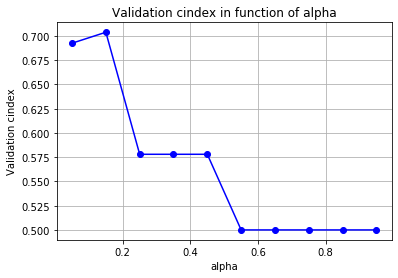

In [38]:
plt.figure()
plt.plot(lst_alphas, lst_cindex ,'b-o')
plt.grid()
plt.xlabel("alpha")
plt.ylabel("Validation cindex")
plt.title("Validation cindex in function of alpha")
plt.show()

In [39]:
b = lst_b[np.argmax(lst_cindex)]
print(np.round(b,2))

[ 0.    0.   -0.06  0.   -0.   -0.    0.36 -0.03]


In [40]:
df_X_train.columns[((b>0.0001) | (b<-0.0001))]

Index(['original_shape_Maximum3DDiameter', 'SourceDataset', 'Nstage'], dtype='object')